Data Import

In [2]:
# !pip install gensim

In [3]:
# !pip install vaderSentiment

In [4]:
# %pip install wordcloud

In [5]:
# %pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, roc_curve, auc, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_data = pd.read_csv('Project Data-20250518/train.csv')
test_data = pd.read_csv('Project Data-20250518/test.csv')

In [4]:
train_data.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


In [5]:
train_df = pd.DataFrame(data=train_data).reset_index(drop=True)
test_df = pd.DataFrame(data=test_data).reset_index(drop=True)

In [6]:
train_df

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


In [7]:
test_df

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."
...,...,...
2383,2383,$IVC - Invacare Corporation (IVC) CEO Matthew ...
2384,2384,"Domtar EPS misses by $0.05, revenue in-line"
2385,2385,India Plans Incentives to Bring In Foreign Man...
2386,2386,$NVCR shows institutional accumulation with bl...


### 1. Exploratory Analysis

In [8]:
train_df.shape

(9543, 2)

In [9]:
(train_df['label']).unique()

array([0, 1, 2], dtype=int64)

In [10]:
label_count = train_df["label"].value_counts()

label_map = {0: "Bearish", 1: "Bullish", 2: "Neutral"}
label_distribution = {label_map[i]: int(count) for i, count in label_count.items()}

In [11]:
print(label_map)
print(label_distribution)

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
{'Neutral': 6178, 'Bullish': 1923, 'Bearish': 1442}


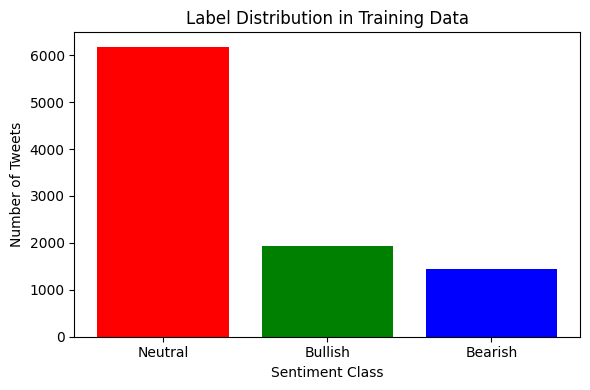

In [12]:
labels = list(label_distribution.keys())
values = list(label_distribution.values())

# Plot the label distribution
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['red', 'green', 'blue'])
plt.title("Label Distribution in Training Data")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment Class")
plt.tight_layout()
plt.show()

In [13]:
(train_df['label']).mean()

1.496279995808446

In [14]:
(train_df['label']).median()

2.0

In [15]:
(train_df['label']).std()

0.7431386657201221

In [16]:
(train_df['label']).describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


Text (Independent Features)

In [18]:
#Check a random text
train_df['text'][105]

'Royal Caribbean downgraded to sell from buy at CFRA'

In [19]:
train_df['text'].isnull().sum()

0

Word Count

In [20]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split(" ")))
train_df[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


Word count - Descriptive statistics

In [21]:
train_df.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

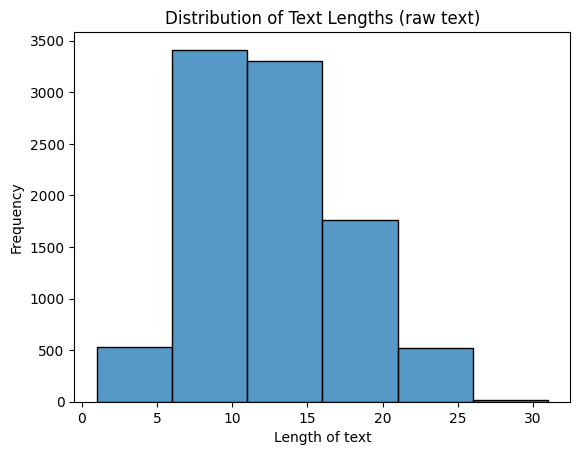

In [22]:
#Plot distribution of text length
sns.histplot(train_df['word_count'], bins=6)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

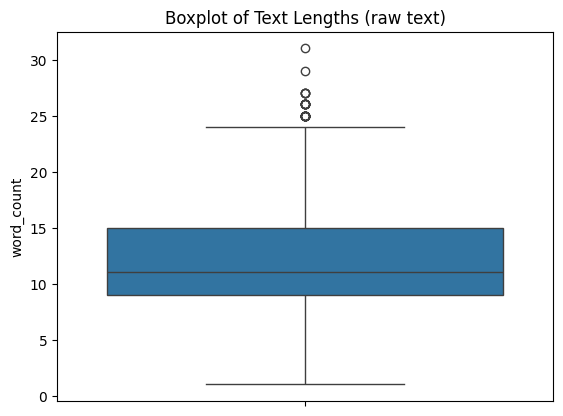

In [23]:
sns.boxplot(train_df['word_count'])
plt.title("Boxplot of Text Lengths (raw text)")
plt.show()

In [24]:
all_words = ' '.join(train_df['text']).split()
frequency = pd.Series(all_words).value_counts()
frequency.sort_values(ascending=False)[:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

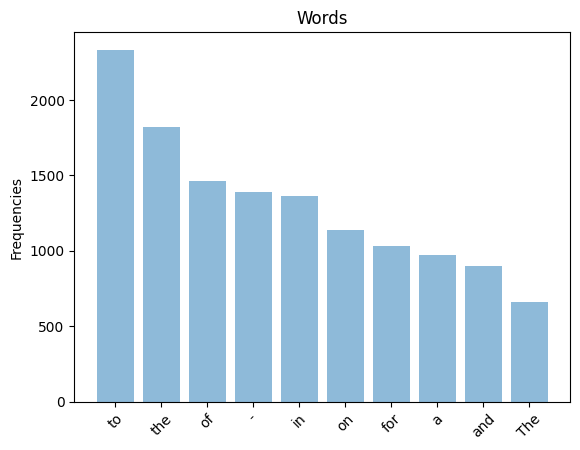

In [25]:
x_labels = frequency.index[:10]
values = frequency[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=45)
plt.show()

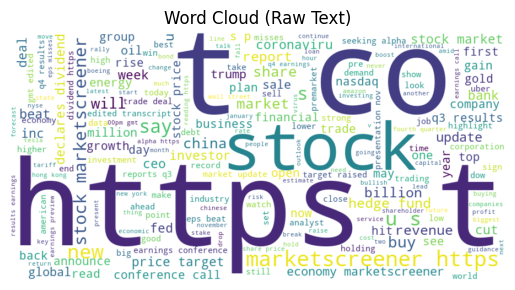

In [26]:
raw_text = ' '.join(train_df['text'].fillna('')).lower()
raw_wordcloud = WordCloud(width=900, height=450, background_color='white').generate(raw_text)
plt.imshow(raw_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [27]:
train_df

,text,label,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,0,10
1,$CCL $RCL - Nomura points to bookings weakness...,0,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,14
3,$ESS: BTIG Research cuts to Neutral https://t....,0,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,10
...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,16
9539,Tupperware Brands among consumer gainers; Unil...,2,9
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,11
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9


In [28]:
test_df

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."
...,...,...
2383,2383,$IVC - Invacare Corporation (IVC) CEO Matthew ...
2384,2384,"Domtar EPS misses by $0.05, revenue in-line"
2385,2385,India Plans Incentives to Bring In Foreign Man...
2386,2386,$NVCR shows institutional accumulation with bl...


In [29]:
train_df["stock"] = train_df["text"].apply(lambda x: re.findall(r"\$\w+", x))

In [30]:
print(train_df['label'].value_counts())
print(train_df['label'].dtype)

label
2    6178
1    1923
0    1442
Name: count, dtype: int64
int64


#### Correlation between Stock companies and the sentiment

In [31]:
# Expand the stock column so each row has one stock symbol per row
exploded = train_df.explode("stock")

# Group by stock and label, count occurrences
stock_sentiment_counts = exploded.groupby(["stock", "label"]).size().unstack(fill_value=0)

# Rename columns to the label_map
stock_sentiment_counts = stock_sentiment_counts.rename(columns=label_map)

# Add a 'Total' column
stock_sentiment_counts['Total'] = stock_sentiment_counts.sum(axis=1)

# Sort by the amount of times it was mentioned
stock_sentiment_counts = stock_sentiment_counts.sort_values('Total', ascending=False)

display(stock_sentiment_counts.head(20))

label,Bearish,Bullish,Neutral,Total
stock,,,,
$0,37,79,179,295
$1,29,54,64,147
$4,6,8,28,42
$3,9,12,19,40
$2,0,16,21,37
$5,10,2,18,30
$SPY,2,8,16,26
$10,4,5,15,24
$COMDX,0,2,21,23


### Corpus Split

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.20, random_state=42, stratify=train_df['label'])

In [33]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7634,), (1909,), (7634,), (1909,))

In [34]:
X_test = test_df['text']

In [35]:
X_test.shape

(2388,)

### Data Preprocessing

In [36]:
# Function to remove URLs, stock symbols, special characters, normalize whitespace, and convert to lowercase

def clean_text(text):
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # Remove stock symbols
    text = re.sub(r"\$\w+[\-:]?\s*", "", text)
    
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    return text

#### Stop Words, Lemmatizer, Stemmer

In [37]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [38]:
# Function that performs removal of stopwords, and uses lemmatization

def remove_stopwords(text, lemmatize=False):
    
    # Apply the clean_text function
    text = clean_text(text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop and word not in string.punctuation]
    
    # Lemmatize the words
    if lemmatize:
        tokens = [lemma.lemmatize(word) for word in tokens]
        
    # stemmed_words = [stemmer.stem(word) for word in tokens]
    # stemmed_words = ' '.join(stemmed_words)
    
    return ' '.join(tokens)

In [39]:
# Training
X_train = X_train.apply(lambda x: remove_stopwords(x, lemmatize=True))

# Validation/Test
X_val = X_val.apply(lambda x: remove_stopwords(x, lemmatize=False))
X_test = X_test.apply(lambda x: remove_stopwords(x, lemmatize=False))

In [40]:
X_train

2186                   nasdaq price 600m 0875 senior note
6819                                               future
6157    november nonfarm private payroll 125k v 153k c...
2462    twitter user explain kohl stock got obliterate...
4097    agilysys restaurant find sustainable method li...
                              ...                        
2807                       japan tobacco report fy result
704     fed emergence power player pose new risk indep...
990     rise athome fitness service could benefit lulu...
4362                    daniel loeb top 5 buy 3rd quarter
7664    zee entertainment subhash chandra resigns chai...
Name: text, Length: 7634, dtype: object

#### Define training features - Bag of Words

In [41]:
bow = CountVectorizer(binary=True, stop_words='english')
X_bow = bow.fit_transform(X_train)
# X_bow_stem = bow.fit_transform(X_train_stem)
X_bow_valid = bow.transform(X_val)
X_bow_test = bow.transform(test_df['text'])

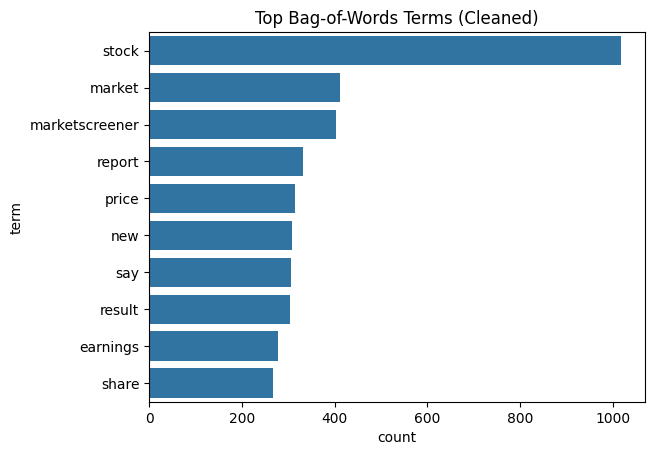

In [42]:
# Visualize top Bag of Words terms (Cleaned)

# Use the vectorizer fit on lemmatized data for both matrix and feature names
bow_lem = CountVectorizer(binary=True, stop_words='english')

X_bow = bow_lem.fit_transform(X_train)

clean_bow_sum_lem = np.array(X_bow.sum(axis=0)).flatten()

clean_terms = bow_lem.get_feature_names_out()

clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum_lem}).sort_values(by='count', ascending=False).head(10)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

In [43]:
# # Visualize top Bag of Words terms (Cleaned)

# # Use the vectorizer fit on stemmed data for both matrix and feature names
# bow_stem = CountVectorizer(binary=True, stop_words='english')

# X_bow_stem = bow_stem.fit_transform(X_train_stem)

# clean_bow_sum_stem = np.array(X_bow_stem.sum(axis=0)).flatten()

# clean_terms = bow_stem.get_feature_names_out()

# clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum_stem}).sort_values(by='count', ascending=False).head(10)

# sns.barplot(data=clean_top, x='count', y='term')
# plt.title("Top Bag-of-Words Terms (Cleaned)")
# plt.show()

TF-IDF

In [44]:
tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))

In [45]:
X_tfidf = tfidf.fit_transform(X_train).toarray()

In [46]:
# X_tfidf_stem = tfidf.fit_transform(X_train_stem).toarray()

In [47]:
X_valid_tfidf = tfidf.transform(X_val).toarray()

In [48]:
X_test_tfidf = tfidf.transform(X_test).toarray()

VADER

In [49]:
analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']],
                     index=["vader_neg", "vader_neu", "vader_pos", "vader_compound"])


In [50]:
# Add VADER features to training set
X_train_vader = X_train.apply(vader_scores)
X_valid_vader = X_val.apply(vader_scores)
X_test_vader = X_test.apply(vader_scores)

Define Labels

In [51]:
y = np.array(y_train)

In [52]:
y_valid = np.array(y_val)

In [53]:
y[0:10]

array([2, 1, 0, 0, 2, 2, 2, 2, 2, 2], dtype=int64)

In [54]:
len(y)

7634

Train Classifier

In [55]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [56]:
modelknn.fit(X_tfidf,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [57]:
y_valid_pred = modelknn.predict(X_valid_tfidf)

In [58]:
silhouette_score(X_valid_tfidf, y_valid_pred)

0.0020750915406073643

Embeddings

In [59]:
dim=200

In [60]:
glove_model = api.load(f'glove-twitter-{dim}')

In [61]:
#Extract sentence embeddings from X_train_clean by averaging word embeddings per sentence ---
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [62]:
X_train_glove = np.array([average_embedding(text, glove_model, dim=dim) for text in X_train])
X_valid_glove = np.array([average_embedding(text, glove_model, dim=dim) for text in X_val])
X_test_glove  = np.array([average_embedding(text, glove_model, dim=dim) for text in X_test])

In [63]:
import numpy as np

X_train_combined = np.hstack([X_train_glove, X_train_vader.values])
X_valid_combined = np.hstack([X_valid_glove, X_valid_vader.values])
X_test_combined  = np.hstack([X_test_glove,  X_test_vader.values])


### RNN

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN ,SpatialDropout1D, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [65]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [66]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [67]:
max_seq_length = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

In [68]:
# Build embedding matrix for Keras Embedding layer
embedding_dim = dim
vocab_size = min(10000, len(tokenizer.word_index) + 1)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]


In [69]:
# Recurrent Neural Network

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_seq_length,
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [72]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y = y)
class_weight_dict = dict(enumerate(class_weights))

In [73]:
history = model.fit(X_train_glove, y, epochs=20, batch_size=32, verbose=1, class_weight=class_weight_dict)

valid_preds_glove = model.predict(X_valid_glove)
test_preds_glove = model.predict(X_test_glove)

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 47s 180ms/step - accuracy: 0.5324 - loss: 1.1246
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.4457 - loss: 1.0945
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.5946 - loss: 1.0768
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.4545 - loss: 1.1032
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.5682 - loss: 1.0876
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.3864 - loss: 1.1020
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.4665 - loss: 1.1028
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.6081 - loss: 1.0979
Epoch 9/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.5685 - loss: 1.0974
Epoch 10/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.3950 - loss: 1.1073
Epoch 11/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.3128 - loss: 1.1122
Epoch 12/20
239/239

In [74]:
# Classification report for validation set
print(classification_report(y_valid, np.argmax(valid_preds_glove, axis=1), target_names=label_map.values()))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00       288
     Bullish       0.00      0.00      0.00       385
     Neutral       0.65      1.00      0.79      1236

    accuracy                           0.65      1909
   macro avg       0.22      0.33      0.26      1909
weighted avg       0.42      0.65      0.51      1909



c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo